In [1]:
import argparse
import json
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import tf
import actionlib
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
import os
import csv
import cv2
from nerf_vision_utils import *
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Get relative path to the current file
PATH = os.getcwd()
print(PATH)
CONGIG_PATH = os.path.join(PATH, '../json/jackal.json')

#Read the config file as a json
move_base_frame = ""
camera_topic = ""
camere_frame = ""
robot_frame = ""

with open(CONGIG_PATH) as f:
    config_dict = json.load(f)
    camera_topic = config_dict["camera_topic"]
    camera_frame = config_dict["camera_frame"]
    robot_frame = config_dict["robot_frame"]
    move_base_frame = config_dict["move_base_frame"]
print("Camera Topic:", camera_topic)
print("Camera Frame:", camera_frame)
print("Robot Frame:", robot_frame)
print("Move Base Frame:", move_base_frame)

#Read the coordinates file as a csv
COORDINATES_PATH = os.path.join(PATH, '../targets/3_pts.csv')
coordinates = []
with open(COORDINATES_PATH) as f:
    reader = csv.reader(f)
    for row in reader:
        #Convert the string to float
        row = [float(i) for i in row]
        coordinates.append(row)
print(coordinates)

SAVE_PATH = os.path.join(PATH, '../data/3_pts')
print("Save Path:", SAVE_PATH)
#Create the save path if it does not exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)


/home/boomalope/nerf_estimator/src/nerf_estimator/nerf_vision/scripts
Camera Topic: /camera/camera1/image_raw
Camera Frame: camera_link_optical
Robot Frame: base_link
Move Base Frame: world
[[2.0, 0.0, 0.0], [2.0, 0.0, 0.08726646259971647], [2.0, 0.0, 0.17453292519943295], [2.0, 0.0, 0.2617993877991494], [2.0, 0.0, 0.3490658503988659], [2.0, 0.0, 0.4363323129985824], [2.0, 0.0, 0.5235987755982988], [2.0, 0.0, 0.6108652381980153], [2.0, 0.0, 0.6981317007977318], [2.0, 0.0, 0.7853981633974483], [2.0, 0.0, 0.8726646259971648], [2.0, 0.0, 0.9599310885968811], [2.0, 0.0, 1.0471975511965976], [2.0, 0.0, 1.1344640137963142], [2.0, 0.0, 1.2217304763960306], [2.0, 0.0, 1.308996938995747], [2.0, 0.0, 1.3962634015954636], [2.0, 0.0, 1.4835298641951802], [2.0, 0.0, 1.5707963267948966], [2.0, 0.0, 1.658062789394613], [2.0, 0.0, 1.7453292519943295], [2.0, 0.0, 1.8325957145940461], [2.0, 0.0, 1.9198621771937623], [2.0, 0.0, 2.007128639793479], [2.0, 0.0, 2.0943951023931953], [2.0, 0.0, 2.181661564992

In [3]:
rospy.init_node('data_collection')

#Initialize the odom injector
client = actionlib.SimpleActionClient("move_base",MoveBaseAction)
client.wait_for_server()

current_camera_img = None
#Initialize the camera subscriber
def callback(data):
    global current_camera_img
    cv_image = getCameraTopicAsCvImage(data)
    #Convert the image to BGR
    cv_image = cv2.cvtColor(cv_image, cv2.COLOR_RGB2BGR)
    current_camera_img = cv_image
# Subscribe to the camera topic
rospy.Subscriber(camera_topic, Image, callback)

Going to:  [3.5, 0.0, 6.19591884457987]
Reached:  [3.5, 0.0, 6.19591884457987]
xyz:  [3.825001875716365, -0.06835092068140652, -0.101357786788141]
q:  [0.026299946129432785, -0.2573548241440603, -0.09946733506610722, 0.9608241548682129]


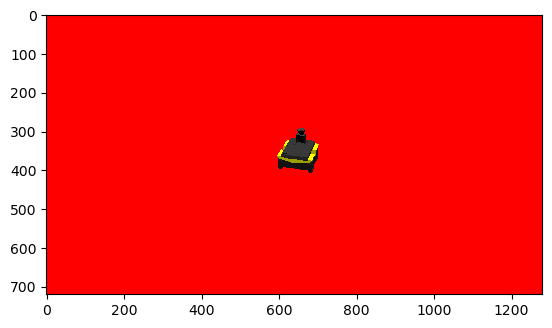

In [4]:
#Iterate through coordiates, capturing a picture and pose once arriving at each coordinate
client = actionlib.SimpleActionClient("move_base",MoveBaseAction)
client.wait_for_server()
for i, c in enumerate(coordinates):
    #Clear the output
    clear_output(wait=True)

    print("Going to: ", c)
    
    #Navigate to goal
    goal = getMoveBaseGoal(move_base_frame, c[0], c[1], c[2])
    client.send_goal(goal)
    client.wait_for_result()
    print("Reached: ", c)

    #Calculate relative pose
    xyz, q = getRobotPose(camera_frame, robot_frame)
    print("xyz: ", xyz)
    print("q: ", q)

    #Capture image
    plt.imshow(current_camera_img)
    plt.show()

    #Save image and pose
    img_name = str(i) + '.png'
    pose_name = str(i) + '.txt'
    img_path = os.path.join(SAVE_PATH, img_name)
    pose_path = os.path.join(SAVE_PATH, pose_name)
    cv2.imwrite(img_path, current_camera_img)
    with open(pose_path, 'w') as f:
        xyz_string = str(xyz[0])+', '+ str(xyz[1])+', '+str(xyz[2])
        q_string = str(q[0]) + ', ' + str(q[1]) + ', ' + str(q[2]) + ', ' + str(q[3])
        goal_string = str(c[0])+', '+str(c[1])+', '+str(c[2])
        f.write(xyz_string+', '+q_string+', '+goal_string)